# 分类

### 数据集 MNIST

In [1]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape) #MNIST有0000张图片，每张图片有784个特征。这是因为每个图片都是28*28像素的，并且每个像素的值介于0~255之间

(70000, 784) (70000,)


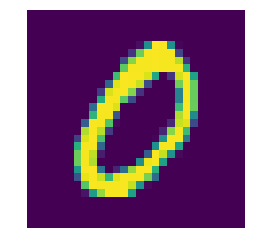

label:  0.0


In [3]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

some_digit = X[4000]
some_digit_image = some_digit.reshape((28,28)) # 1*784的向量 -> 28*28的像素矩阵
plt.imshow(some_digit_image)
plt.axis("off")
plt.show()
print("label: ", y[4000])

### 划分数据集

In [4]:
# mnist数据集已经划分为一个训练集(前60000张图片)和一个测试集(后10000张图片)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 打乱训练集。这可以保证交叉验证的每一折都是相似,
# 且一些学习算法对训练样例的顺序敏感，当它们在一行当中得到许多相似的样例，这些算法将会表现得非常差。打乱数据集将保证这种情况不会发生

import numpy as np

shuffle_index = np.random.permutation(60000) # 打乱下标
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] 

### 训练一个二分类器

In [5]:
# 简化一下问题，只尝试去识别一个数字,比如数字0， 使得模型能够区分 0和非0

y_train_0 = (y_train==0)
y_test_0 = (y_test==0)

In [6]:
# 随机梯度下降分类器SGD, 有一个好处是能够高效地处理非常大的数据集, 部分原因在于SGD一次只处理一条数据，这也使得SGD适合在线学习

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=1) # 使得结果可重现
sgd_clf.fit(X_train ,y_train_0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [7]:
sgd_clf.predict([some_digit]) # 可以用它来查出数字0的图片

array([ True])

### 对性能的评估

#### 交叉验证

In [8]:
# 下面实现一个自定义的交叉验证

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 定义一个切割器 StratifiedKFold 类实现了分层采样生成的折（fold）包含了各类相应比例的样例
skfolds = StratifiedKFold(n_splits=3, random_state=42) # 3折交叉验证
for train_index, test_index in skfolds.split(X_train, y_train_0):
    # 生成分类器的克隆版本，防止对原生成器的破坏
    clone_clf = clone(sgd_clf)
    # 获取每一折的数据
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_folds = y_train_0[train_index]
    y_test_folds = y_train_0[test_index]
    # 在克隆版本上进行训练
    clone_clf.fit(X_train_folds, y_train_folds)
    # 在克隆版本上进行测试
    y_pred = clone_clf.predict(X_test_folds)
    # 计算出被正确预测的数目和输出正确预测的比例
    print( sum(y_pred == y_test_folds) / len(y_test_folds) )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9887005649717514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9896


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9871993599679983


In [11]:
# 使用cross_val_score()函数来评估SGDClassifier模型，同时使用K折交叉验证
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([0.98870056, 0.9896    , 0.98719936])

#### 混淆矩阵

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

In [13]:
# 现在使用confusion_matrix()函数，将会得到一个混淆矩阵
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_0, y_train_pred)

array([[53825,   252],
       [  438,  5485]], dtype=int64)

In [14]:
from sklearn.metrics import precision_score, recall_score

print(
    precision_score(y_train_0, y_train_pred),
    recall_score(y_train_0, y_train_pred)
)

0.9560746034512811 0.9260509876751646


In [15]:
# f1 = 2 * (precision * recall) / (precision + recall)

from sklearn.metrics import f1_score

f1_score(y_train_0, y_train_pred)

0.9408233276157804

### 多类分类

### 误差分析

In [16]:
# 假设已经找到一个不错的模型，怎么去改善它。首先想到的应该是分析模型产生的误差的类型。
# 可以检查混淆矩阵。你需要使用cross_val_predict()做出预测，然后调用confusion_matrix()函数
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_train_pred)
print(conf_mat)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

[[5667    2   38   42   21   56   45    9   32   11]
 [   3 6433   28   36    9   54   12   16  138   13]
 [  90  117 4937  199  112   46   95  114  226   22]
 [  49   50  121 5395   14  147   25   48  223   59]
 [  21   34   16   21 5388   12   41   30  100  179]
 [ 108   38   27  397  138 4138   97   33  352   93]
 [  72   32   51   17   75  104 5515    9   41    2]
 [  31   33   45   42  103   15    7 5649   86  254]
 [  84  262  143  509  147  468   60   69 3944  165]
 [  59   48   22  142  361   44    2  242  175 4854]]


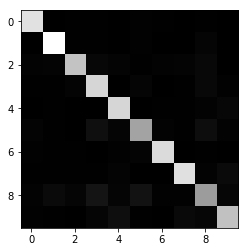

In [17]:
# 使用Matplotlib的matshow()函数，将混淆矩阵以图像的方式呈现，将会更加方便。
plt.imshow(conf_mat, cmap=plt.cm.gray)
plt.show()

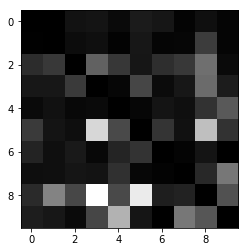

In [18]:
row_sum = np.sum(conf_mat, axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sum
# 用0来填充对角线。这样子就只保留了被错误分类的数据
np.fill_diagonal(norm_conf_mat, 0)

# 接着画出来
plt.imshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

## 多输出分类，多标签分类

## Question 1

In [ ]:
# 尝试在MNIST数据集上建立一个分类器，使它在测试集上的精度超过97%
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [4, 5, 6, 7], 'weights': ['uniform', 'distance']}
]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=4)
grid_search.fit(X_train, y_train)

## Question 2

## Question 3